In [1]:
from fastai import *
from fastai.vision import *

from ranger import Ranger

PATH = Path('..').resolve()

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from morphomap import *

flat_np = lambda arr: to_np(arr.reshape(-1))

Mish activation loaded...
Mish activation loaded...


In [3]:
df = pd.read_csv(PATH/'data'/'combined.csv', index_col=0)
df.sample(2)

,id,logfgas
601,AGC_181124,-0.732030
681,GASS_112017,-1.485894


# Train

In [4]:
bs = 32
sz = 224

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [5]:
il = ImageList.from_df(df, path=PATH, folder='images', suffix='.jpg', cols='id')

src = (il.split_by_rand_pct(0.2)
         .label_from_df(cols='logfgas',  label_cls=FloatList)
)

data = (src.transform(tfms, size=sz)
           .databunch(bs=bs)
           .normalize(image_stats)
)

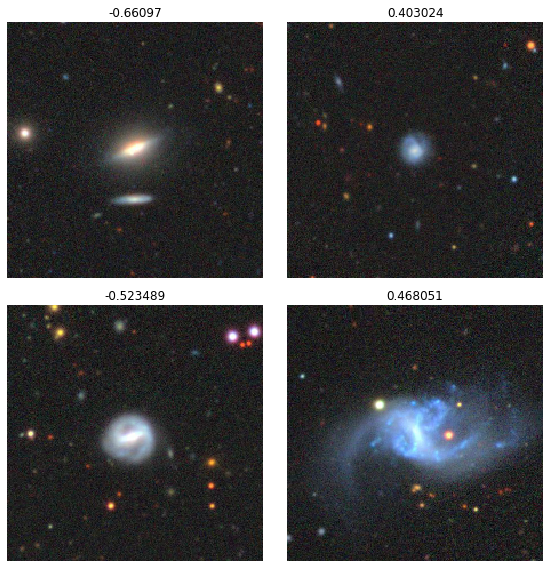

In [15]:
data.show_batch(2)

In [69]:
model = mxresnet18()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True).cuda()

In [70]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-4,
    bn_wd=False,
    true_wd=True,
)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


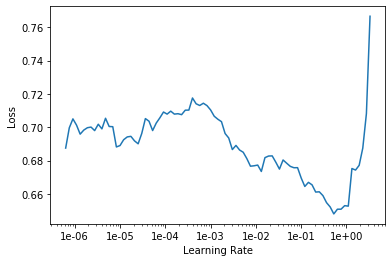

In [71]:
learn.lr_find()
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(30, 3e-2, wd=1e-4)

epoch,train_loss,valid_loss,time
0,0.495787,0.480798,00:22
1,0.384686,0.323077,00:23
2,0.377074,0.478003,00:22
3,0.368593,0.304102,00:22
4,0.366603,0.461778,00:22
5,0.358614,0.315438,00:22
6,0.352421,0.487740,00:22
7,0.358792,0.463550,00:23
8,0.343115,0.515653,00:22
9,0.337585,0.324601,00:22


In [74]:
preds, trues = learn.TTA(scale=1.)

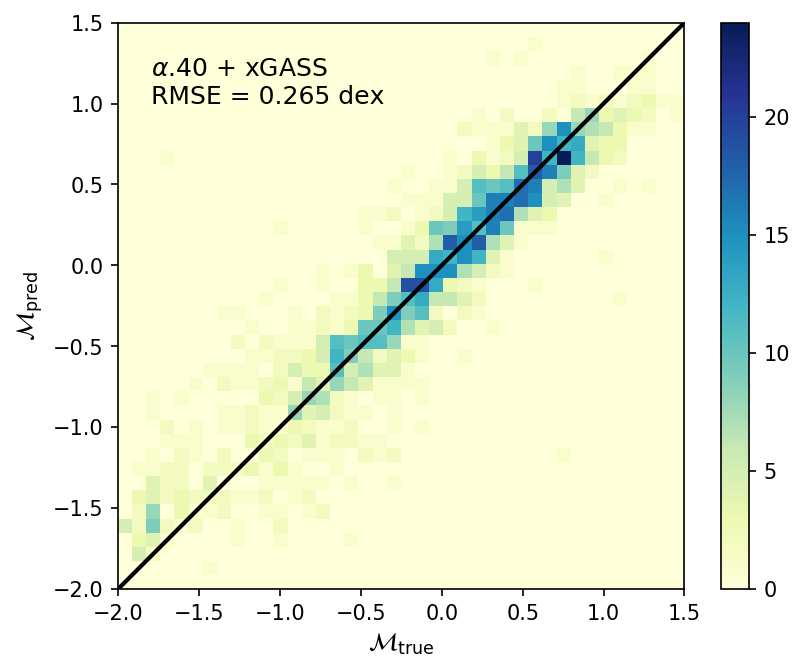

In [79]:
plt.figure(figsize=(6.2, 5), dpi=150)
plt.hist2d(flat_np(trues), flat_np(preds), cmap='YlGnBu', range=[(-2, 1.5), (-2, 1.5)], bins=40);
plt.plot([-2, 2], [-2, 2], c='black', ls='-', lw=2)

plt.gca().set_aspect('equal')
plt.colorbar();

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12);
plt.xticks(np.arange(-2, 2., .5))
plt.yticks(np.arange(-2, 2., .5));

rmse = root_mean_squared_error(trues, preds)
plt.text(-1.8, 1., r'$\alpha$.40 + xGASS' +'\n' + f'RMSE = {rmse:.3f} dex', fontsize=12);


# Deeper model

In [10]:
model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True).cuda()

In [11]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-4,
    bn_wd=False,
    true_wd=True,
)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


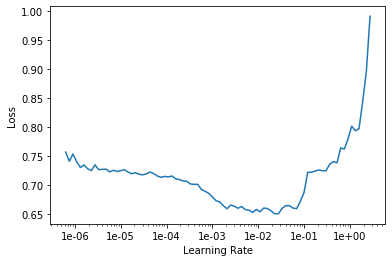

In [8]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(80, 1e-3, wd=1e-4)

epoch,train_loss,valid_loss,time
0,0.568787,0.618014,00:59
1,0.504205,0.495674,00:57
2,0.451492,0.431429,00:57
3,0.432374,0.413282,00:56
4,0.407335,0.424961,00:57
5,0.407027,0.375910,00:57
6,0.373655,0.438075,00:57
7,0.365802,0.384502,00:57
8,0.372334,0.354984,00:57
9,0.360428,0.303974,00:57


In [13]:
# learn.save('combined-mxresnet50_80ep');
learn.load('combined-mxresnet50_80ep');

In [14]:
preds, trues = learn.TTA(scale=1.)

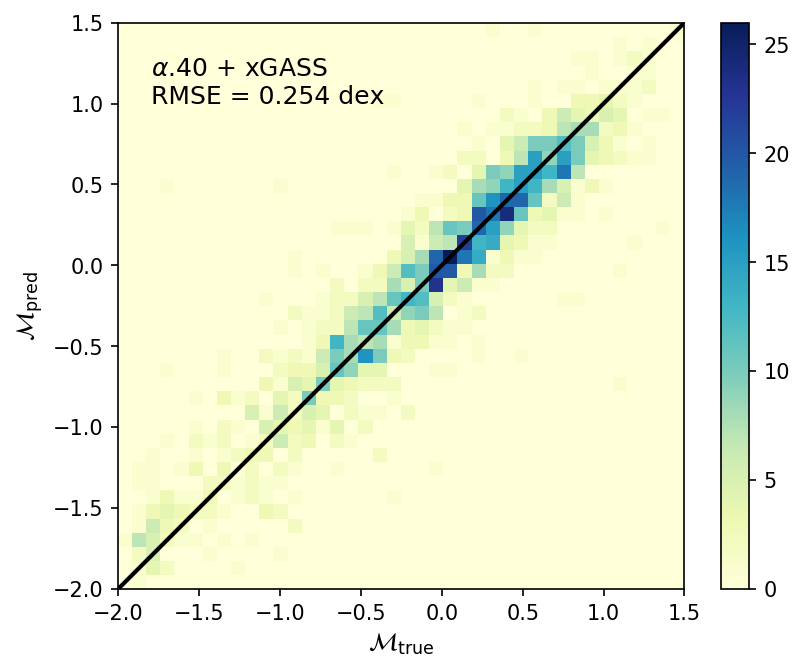

In [15]:
plt.figure(figsize=(6.2, 5), dpi=150)
plt.hist2d(flat_np(trues), flat_np(preds), cmap='YlGnBu', range=[(-2, 1.5), (-2, 1.5)], bins=40);
plt.plot([-2, 2], [-2, 2], c='black', ls='-', lw=2)

plt.gca().set_aspect('equal')
plt.colorbar();

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12);
plt.xticks(np.arange(-2, 2., .5))
plt.yticks(np.arange(-2, 2., .5));

rmse = root_mean_squared_error(trues, preds)
plt.text(-1.8, 1., r'$\alpha$.40 + xGASS' +'\n' + f'RMSE = {rmse:.3f} dex', fontsize=12);


# Test custom methods (will be in `src`)

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

from ranger import Ranger
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

PATH = Path('..').resolve()

sys.path.append(f'{PATH}/src')
from mxresnet import *

Mish activation loaded...
Mish activation loaded...


In [54]:
def get_combined_data(bs=32, sz=224, legacy=False, seed=None):
    df = pd.read_csv(PATH/'data'/'combined.csv', index_col=0)

    if legacy:
        image_stats = [tensor([-0.0443, -0.0643, -0.0726]), tensor([0.9129, 0.8815, 0.8759])]
    else:
        image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]
        
    tfms = get_transforms(
        do_flip=True,
        flip_vert=True,
        max_zoom=1.0,
        max_rotate=15.0,
        max_lighting=0,
        max_warp=0,
    )

    bs = bs
    sz = sz

    il = ImageList.from_df(df, path=PATH, folder='images'+('-legacy' if legacy else ''), suffix='.jpg', cols='id')

    src = (il.split_by_rand_pct(0.2)
             .label_from_df(cols='logfgas',  label_cls=FloatList)
    )

    data = (src.transform(tfms, size=sz)
               .databunch(bs=bs)
               .normalize(image_stats)
    )

    return data



def custom_cnn_learner(
    bs=32, 
    sz=224, 
    legacy=False, 
    cnn_model=mxresnet34, 
    load_model=None
):

    data = get_combined_data(bs=bs, sz=sz, legacy=legacy)

    model = cnn_model()
    model[-1] = nn.Linear(model[-1].in_features, 1, bias=True).cuda()

    learn = Learner(
        data,
        model=model,
        opt_func=partial(Ranger),
        loss_func=root_mean_squared_error,
        wd=1e-4,
        bn_wd=False,
        true_wd=True,
    )

    return learn

In [55]:
learn = custom_cnn_learner(bs=32, sz=224, legacy=False, cnn_model=mxresnet50)

/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py:261: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 4955,4785,3129,2807,5305...
  warn(warn_msg)


You can deactivate this warning by passing `no_check=True`.


In [10]:
learn.load('combined-mxresnet50_80ep');

set state called


# Train on Legacy imaging

In [66]:
learn = custom_cnn_learner(bs=32, sz=224, legacy=True, cnn_model=mxresnet18)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


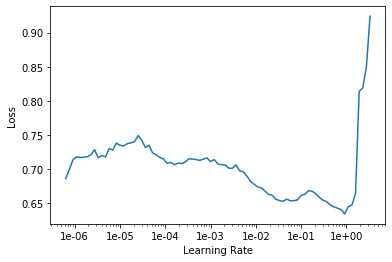

In [67]:
learn.lr_find()
learn.recorder.plot()

In [68]:
learn.fit_one_cycle(5, 1e-2, wd=1e-4)

epoch,train_loss,valid_loss,time
0,0.483252,0.428360,00:28
1,0.382500,0.326294,00:28
2,0.331800,0.350612,00:28
3,0.322927,0.309224,00:28
4,0.310513,0.290593,00:28


## Use manifold mixup 

Code from https://github.com/nestordemeure/ManifoldMixup, originally forked from https://github.com/vikasverma1077/manifold_mixup

In [63]:
from manifold_mixup import *

In [64]:
learn = (
    custom_cnn_learner(bs=32, sz=224, legacy=True, cnn_model=mxresnet18)
        .manifold_mixup(stack_y=False)                # stack_y=False -> combines output, usefulf for regression
)

In [65]:
# note that Mish should be a mixable type
learn.fit_one_cycle(5, 1e-2, wd=1e-4)

38 modules eligible for mixup


epoch,train_loss,valid_loss,time
0,0.439831,0.480732,00:29
1,0.373597,0.338579,00:29
2,0.348167,0.321454,00:29
3,0.307630,0.288961,00:29
4,0.296334,0.284906,00:29


/home/jupyter/HI-diversity/src/manifold_mixup.py:140: Warning: One of the mixup modules (<class 'mxresnet.Mish'>) defined in the model is used more than once in forward pass.
Mixup will happen only at first call. This warning might be due to :
- a recurent modules being intrumented or a single module being aplied to different inputs (you should add those modules to `non_mixable_module_types` as they might interfere with mixup),
- a module being applied to its own output in a loop (in which case you can safely ignore this warning).
  Warning)


## Flat+cosine

In [73]:
learn = (
    custom_cnn_learner(bs=32, sz=224, legacy=True, cnn_model=mxresnet18)
        .manifold_mixup(stack_y=False)                # stack_y=False -> combines output, usefulf for regression
)

In [74]:
learn.fit_fc(5, 1e-2, wd=1e-4, start_pct=0.6)

38 modules eligible for mixup


epoch,train_loss,valid_loss,time
0,0.394880,0.564624,00:29
1,0.347204,0.310210,00:29
2,0.340544,0.316796,00:28
3,0.338609,0.311434,00:29
4,0.299494,0.286953,00:29


/home/jupyter/HI-diversity/src/manifold_mixup.py:140: Warning: One of the mixup modules (<class 'mxresnet.Mish'>) defined in the model is used more than once in forward pass.
Mixup will happen only at first call. This warning might be due to :
- a recurent modules being intrumented or a single module being aplied to different inputs (you should add those modules to `non_mixable_module_types` as they might interfere with mixup),
- a module being applied to its own output in a loop (in which case you can safely ignore this warning).
  Warning)


# Try t-SNE for combined ALFALFA + xGASS model

In [4]:
learn = custom_cnn_learner(bs=32, sz=224, legacy=False, cnn_model=mxresnet50)
learn.load('combined-mxresnet50_80ep');

data = learn.data
m = learn.model.eval();

set state called


## final conv layer

In [5]:
target_layer = m[-4][-1].convs[-1]

In [6]:
N_valid = len(learn.data.valid_dl.items)
valid_acts = np.zeros(shape=(N_valid, 2048*7*7))

# grab all activations for validation set
for i, fn in tqdm(enumerate(data.valid_dl.items), total=N_valid):
    img = open_image(fn);
        
    # get single item
    X, _ = data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(target_layer) as hook_a:
        pred = m(X.cuda())
    
        valid_acts[i] = hook_a.stored[0].cpu().numpy().reshape(-1)

In [7]:
# reduce dimensionality with PCA, otherwise this takes forever
valid_acts_pca = PCA(n_components=20).fit_transform(valid_acts)

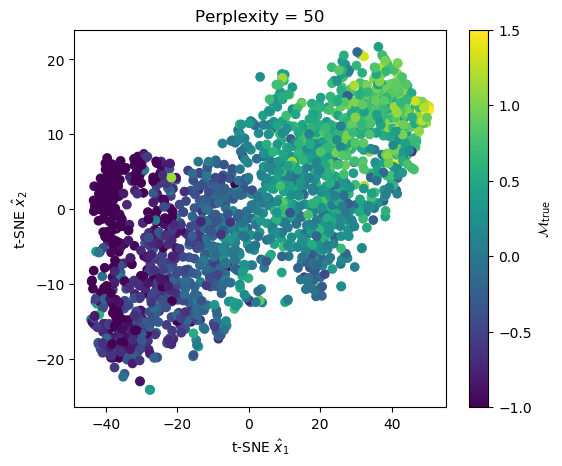

In [10]:
# then use t-SNE to deproject further
perplexity = 50
valid_acts_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(valid_acts_pca)

plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(valid_acts_tsne[:, 0], valid_acts_tsne[:, 1], c=data.valid_ds.y.items, vmin=-1, vmax=1)

cb = plt.colorbar()

plt.title(f'Perplexity = {perplexity}')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r't-SNE $\hat x_1$')
plt.ylabel(r't-SNE $\hat x_2$')

plt.show()

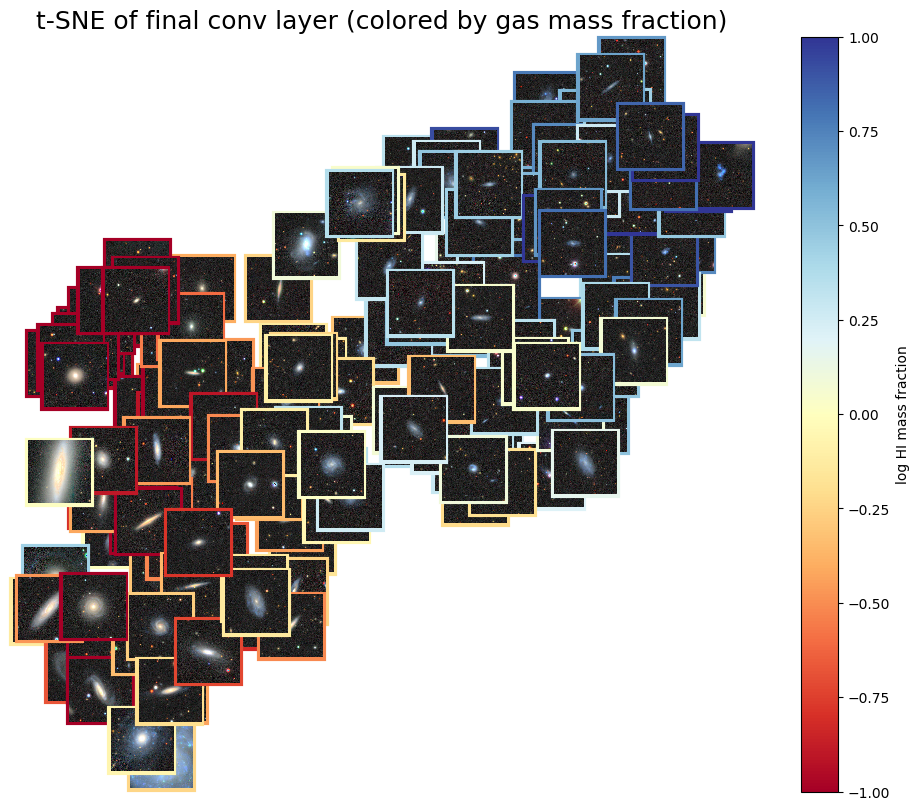

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=100)

sc = ax.scatter(valid_acts_tsne[::10, 0], valid_acts_tsne[::10, 1], c=data.valid_ds.y.items[::10], 
           vmin=-1, vmax=1, cmap='RdYlBu')


plt.title('t-SNE of final conv layer (colored by gas mass fraction)', fontsize=18)

artists = []
for fname, lgGF, [x, y] in zip(data.valid_dl.items[::10], data.valid_ds.y.items[::10], valid_acts_tsne[::10, 0:2]):
    ab = AnnotationBbox(
        OffsetImage(image2np(open_image(fname).data), zoom=0.1), 
        (x, y), 
        xycoords='data', 
        frameon=True, 
        pad=0.1, 
        bboxprops=dict(linewidth=3, edgecolor=plt.cm.RdYlBu((lgGF+1)/2))
    )
    artists.append(ax.add_artist(ab))
plt.axis('off')

    
plt.colorbar(sc, label='log HI mass fraction')


## final linear layer

In [29]:
target_layer = m[-2]

In [31]:
N_valid = len(learn.data.valid_dl.items)
valid_acts = np.zeros(shape=(N_valid, 2048))

# grab all activations for validation set
for i, fn in tqdm(enumerate(data.valid_dl.items), total=N_valid):
    img = open_image(fn);
        
    # get single item
    X, _ = data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(target_layer) as hook_a:
        pred = m(X.cuda())
    
        valid_acts[i] = hook_a.stored[0].cpu().numpy().reshape(-1)

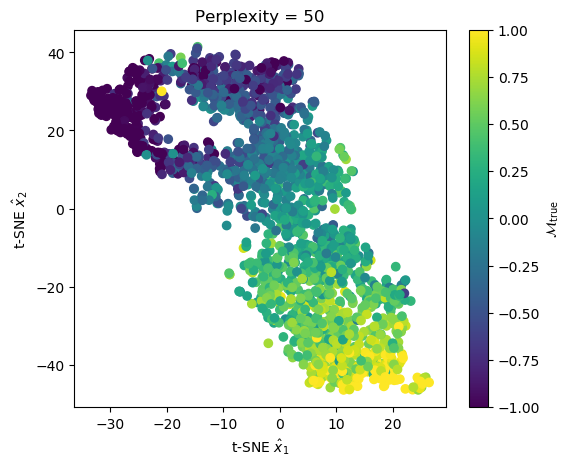

In [34]:
valid_acts_pca = PCA(n_components=20).fit_transform(valid_acts)

perplexity = 50
valid_acts_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(valid_acts_pca)

plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(valid_acts_tsne[:, 0], valid_acts_tsne[:, 1], c=data.valid_ds.y.items, vmin=-1, vmax=1)

cb = plt.colorbar()

plt.title(f'Perplexity = {perplexity}')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r't-SNE $\hat x_1$')
plt.ylabel(r't-SNE $\hat x_2$')

plt.show()

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=100)

sc = ax.scatter(valid_acts_tsne[::10, 0], valid_acts_tsne[::10, 1], c=data.valid_ds.y.items[::10], 
           vmin=-1, vmax=1, cmap='RdYlBu')


plt.title('t-SNE of final linear layer (colored by gas mass fraction)', fontsize=18)

artists = []
for fname, lgGF, [x, y] in zip(data.valid_dl.items[::10], data.valid_ds.y.items[::10], valid_acts_tsne[::10, 0:2]):
    ab = AnnotationBbox(
        OffsetImage(image2np(open_image(fname).data), zoom=0.1), 
        (x, y), 
        xycoords='data', 
        frameon=True, 
        pad=0.1, 
        bboxprops=dict(linewidth=3, edgecolor=plt.cm.RdYlBu((lgGF+1)/2))
    )
    artists.append(ax.add_artist(ab))
plt.axis('off')

    
plt.colorbar(sc, label='log HI mass fraction')


Error in callback <function flush_figures at 0x7f19531240e0> (for post_execute):


KeyboardInterrupt: 

## A very early layer

In [45]:
target_layer = m[4][-1].convs[-1]
target_layer

Sequential(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [46]:
N_valid = len(learn.data.valid_dl.items)
valid_acts = np.zeros(shape=(N_valid, 256*56*56))

# grab all activations for validation set
for i, fn in tqdm(enumerate(data.valid_dl.items), total=N_valid):
    img = open_image(fn);
        
    # get single item
    X, _ = data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(target_layer) as hook_a:
        pred = m(X.cuda())
    
        valid_acts[i] = hook_a.stored[0].cpu().numpy().reshape(-1)

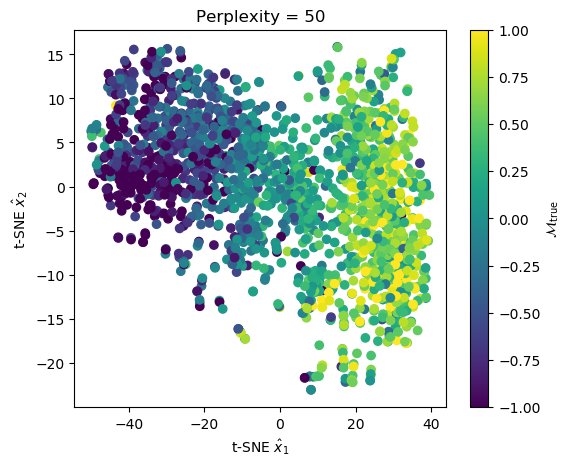

In [47]:
valid_acts_pca = PCA(n_components=20).fit_transform(valid_acts)

perplexity = 50
valid_acts_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(valid_acts_pca)

plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(valid_acts_tsne[:, 0], valid_acts_tsne[:, 1], c=data.valid_ds.y.items, vmin=-1, vmax=1)

cb = plt.colorbar()

plt.title(f'Perplexity = {perplexity}')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r't-SNE $\hat x_1$')
plt.ylabel(r't-SNE $\hat x_2$')

plt.show()

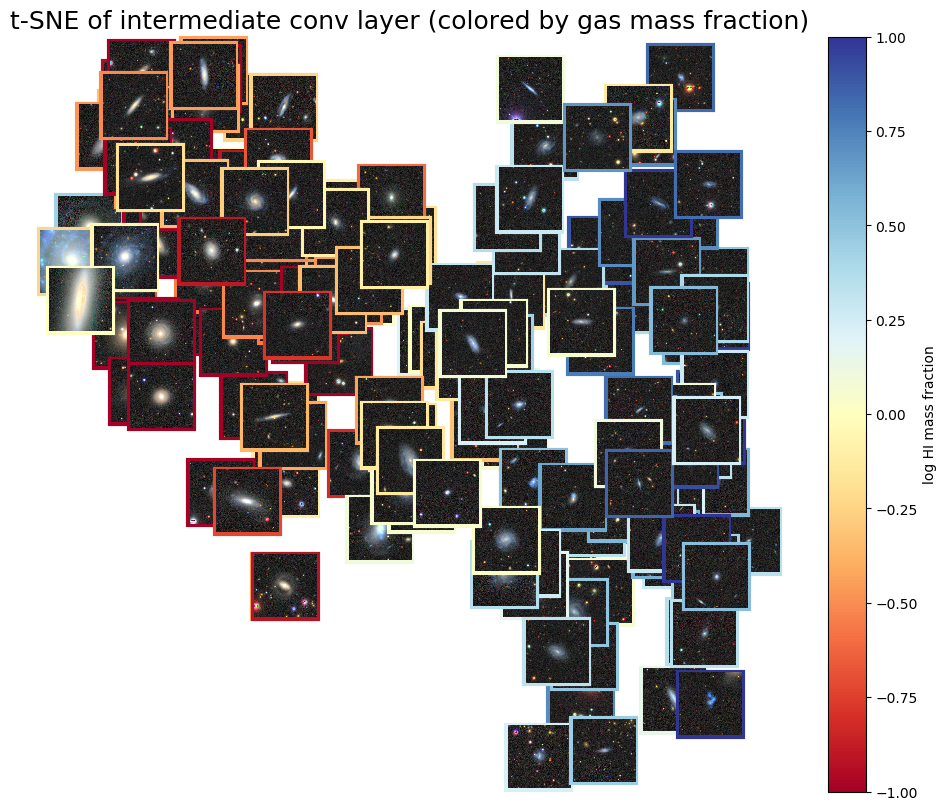

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=100)

sc = ax.scatter(valid_acts_tsne[::10, 0], valid_acts_tsne[::10, 1], c=data.valid_ds.y.items[::10], 
           vmin=-1, vmax=1, cmap='RdYlBu')


plt.title('t-SNE of intermediate conv layer (colored by gas mass fraction)', fontsize=18)

artists = []
for fname, lgGF, [x, y] in zip(data.valid_dl.items[::10], data.valid_ds.y.items[::10], valid_acts_tsne[::10, 0:2]):
    ab = AnnotationBbox(
        OffsetImage(image2np(open_image(fname).data), zoom=0.1), 
        (x, y), 
        xycoords='data', 
        frameon=True, 
        pad=0.1, 
        bboxprops=dict(linewidth=3, edgecolor=plt.cm.RdYlBu((lgGF+1)/2))
    )
    artists.append(ax.add_artist(ab))
plt.axis('off')

    
plt.colorbar(sc, label='log HI mass fraction')
